# Simulating ancestry with msprime

We will use `msprime`, a backwards-time tree sequence simulator, to generate genealogical trees with mutations occurring along them. We will simulate genomic data sets using two demographic models: (1) a simple model with A single, panmictic population and (2) a stepping stone model with six populations.
 
### Why do we do simulations in population genetics?

**Exploration:**
Simulations allow us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance.

**Benchmarking and evaluating methodologies:**
To assess the accuracy of inferential methods, we need test datasets for which the true values of important parameters are known.

**Model training:**
Some methods for ancestry inference are trained on simulated data (e.g., Approximate Bayesian Computation).
This is especially important in studies of complex demographies, where there are many potential parameters and models, making it impractical to specify likelihood functions.

### A brief history of msprime

The first release of `msprime` was an emulation of the popular `ms` coalescent simulator with added support for tree sequences.
However, it has since become an expansive and flexible backwards-in-time simulator for various different models of genetic ancestry and mutation, and even for simplified models of selection.
There is a *forwards-time* simulator named `SLiM` which is not covered in this workshop.

### Backwards simulation

The main characteristic of `msprime` is that is simulates *tree sequences* in *backwards-time*.

<img src="pics/msprime-1.png" width="200" height="200">
<img src="pics/msprime-2.png" width="200" height="200">
<img src="pics/msprime-3.png" width="200" height="200">
<img src="pics/msprime-4.png" width="200" height="200">
<img src="pics/msprime-5.png" width="200" height="200">

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG

import msprime
import tskit
import tsinfer
import tsdate
import demesdraw

## Basic syntax to simulate a tree sequence

To simulate a tree sequence in `msprime`, we use the `sim_ancestry()` method:

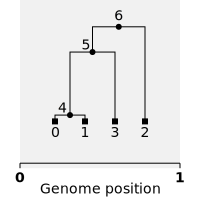

In [3]:
ts = msprime.sim_ancestry(
    samples=2, # two diploid individuals
    random_seed=1
)
SVG(ts.draw_svg())

In [4]:
ts

## Specifying contig information
Although we have specified 2 samples, our tree sequence contains 4 sample nodes.
This is because the `samples` argument specifies the number of *individuals* in the sample,
and by default, `sim_ancestry()` assumes diploid organisms.
To change this, use the `ploidy` argument:

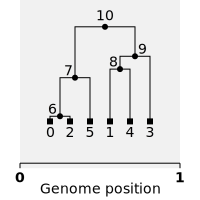

In [5]:
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=1,
    ploidy=3 # two triploid individuals
)
SVG(ts.draw_svg())

It's easiest to start thinking about genome lengths in units of nucleotides. By default, we are simulating a sequence length that spans just one of these units.
We can specify a larger region using the `sequence_length` argument:

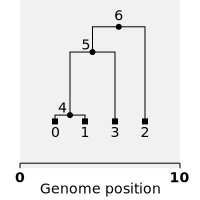

In [6]:
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=1,
    sequence_length=10 # 10 bp long
)
SVG(ts.draw_svg())

Also, note that our 'tree sequence' consists of just a single tree. This is because we have not yet specified a `recombination_rate`, and the default is 0. 
This is the probability of a recombination event per genomic unit (base), per generation.

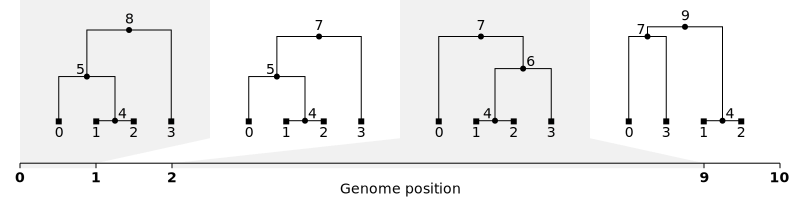

In [13]:
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=82,
    sequence_length=10,
    recombination_rate=0.1 # Allow for recombination to occur
)
SVG(ts.draw_svg())

## Basic syntax to simulation mutations along the tree sequence
To simulate mutations, apply the `sim_mutations()` method to an existing tree sequence object.
At minimum, you must supply a per-base, per-generation mutation rate.

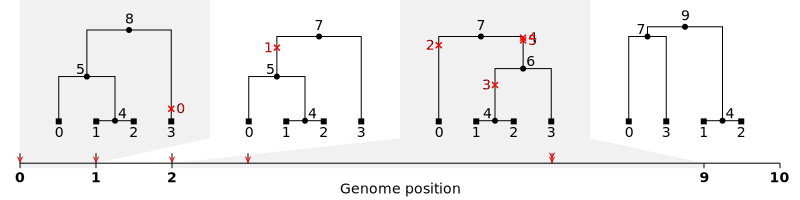

In [17]:
mts = msprime.sim_mutations(
    ts, # generated from the step above
    rate=0.1,
    random_seed=2022
)
SVG(mts.draw_svg())

In [18]:
mts

In [19]:
mts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,3,0.56582134,G,-1,b''
1,1,5,3.31118827,G,-1,b''
2,2,0,3.42268810,C,-1,b''
3,3,4,1.63473292,T,-1,b''
4,4,6,3.75899778,A,-1,b''
5,4,6,3.63911125,T,4,b''


In [20]:
mts.tables.sites

id,position,ancestral_state,metadata
0,0.00000000,C,b''
1,1.00000000,T,b''
2,2.00000000,A,b''
3,3.00000000,G,b''
4,7.00000000,T,b''


Notice that some sites have experienced multiple mutations.
To view the sequence information at each successive site, we can use the `variants()` iterator:

In [21]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

0.0	('C', 'G')	[0 0 0 1]
1.0	('T', 'G')	[1 1 1 0]
2.0	('A', 'C')	[1 0 0 0]
3.0	('G', 'T')	[0 1 1 0]
7.0	('T', 'A')	[0 0 0 0]


## Options
 - Recombination rate variation across the genome. We introduce this by creating a `RateMap` object, which lists recombination rates between defined positions in the sequence.
```
rate_map = msprime.RateMap(position=[0, 10, 20], rate=[0.01, 0.1])
ts = msprime.sim_ancestry(3, recombination_rate=rate_map, random_seed=2)
SVG(ts.draw_svg())
```
 - Note that it's also possible to simulate gene conversion in `msprime`. If this is of interest, have a look at the API documentation for the `gene_conversion_rate` and `gene_conversion_tract_length` arguments, and [this](https://tskit.dev/msprime/docs/stable/ancestry.html?highlight=gene%20conversion#gene-conversion) short tutorial.
 - Stacking mutations
 - Mutation rate variation across the genome
 - Mutation models (pre-defined or custom models)
 - By default, the recombination and mutation events will be assigned to integer locations along the sequence. However there may be situations where you want to model the genome using continuous coordinates. In this case, use the `discrete_genome=False` argument:
```
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=28,
    sequence_length=100,
    recombination_rate=0.01,
    discrete_genome=False
)
SVG(ts.draw_svg())
```

## More complicated demographic models

To simulate under more complicated models of demographic history, we will need to create a `msprime.Demography` object.
`msprime` supports simulation from multiple discrete populations, each of which is initialized via the `add_population()` method.
For each population, you can specify a sample size, an effective population size, an exponential growth rate and a name.
Let's simulate some data using a stepping stone model with six populations.

In [5]:
deme_size = 1_000 # individuals per deme
num_demes = 6
num_deme_samples = 5

In [6]:
demography = msprime.Demography.stepping_stone_model([deme_size] * num_demes,
                                                     migration_rate=0.01)

graph = msprime.Demography.to_demes(demography)

In [7]:
ts = msprime.sim_ancestry(
    {i: num_deme_samples for i in range(num_demes)},
    sequence_length=1e6, # 1 Mbp
    demography=demography,
    recombination_rate=1e-8, # human-like recombination rate
    random_seed=1234,
)

ts = msprime.sim_mutations(ts,
                           rate=1e-8, # human-like mutation rate
                           random_seed=1234
)

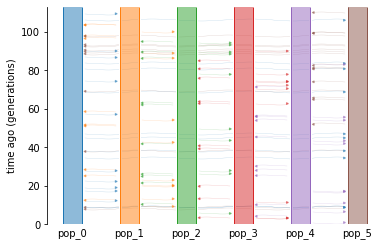

In [8]:
positions = {f"pop_{i}": i*deme_size*3 for i in range(num_demes)}

fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph,
                ax=ax,
                positions=positions,
                seed=111)
plt.show()

## Adding complexity to demographic history
 - Varying population size.
 - Population structure (multiple demes with different migration rates).
 - Migration (constant or varying migration rates).
 - Admixture and population divergence.
 
## Other topics of interest
 - Forward simulations using SLiM.
 - Combining demographic models.
 - Simple selective sweeps.
 - Debugging demographic models.
 
## Some relevant papers
 -  [Efficient coalescent simulation and genealogical analysis for large sample sizes](https://doi.org/10.1371/journal.pcbi.1004842)
 - [Efficient ancestry and mutation simulation with msprime 1.0](https://doi.org/10.1093/genetics/iyab229)
 
## Additional resources
 - [tskit.dev documentation](https://tskit.dev/)
 - tskit community notebooks
 - Georgia's notebooks